In [20]:
# import ipyparallel as ipp

# # create a cluster
# cluster = ipp.Cluster(engines="mpi", n=2)
# # start that cluster and connect to it
# rc = cluster.start_and_connect_sync(activate=True)

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1715096103-p96y:Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

# Built-in Newton Solver

In [1]:
# %%px

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import dolfinx.fem.petsc
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import numpy as np
import pyvista
import ufl

In [2]:
# %%px

def q(u):
    return 1 + u**2

domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
lmbda = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(0.0))

x = ufl.SpatialCoordinate(domain)
u_ufl = (ufl.sin(lmbda) + 0.1* lmbda)*(1 + x[0]* x[0] + 2 * x[1]* x[1]) 

f = - ufl.div(q(u_ufl) * ufl.grad(u_ufl))

V = dolfinx.fem.functionspace(domain, ("Lagrange", 1))
u_D = dolfinx.fem.Function(V)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, fdim + 1)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
bc = dolfinx.fem.dirichletbc(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

uh = dolfinx.fem.Function(V)
v = ufl.TestFunction(V)
F = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - f * v * ufl.dx
# J = ufl.derivative(F, uh)
# residual = dolfinx.fem.form(F)
# jacobian = dolfinx.fem.form(J)

In [3]:
bb_tree = dolfinx.geometry.bb_tree(domain, 2)
bb_point = np.array([[1.0, 1.0, 0.0]], dtype=np.float64)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point)
bb_cells = dolfinx.geometry.compute_colliding_cells(
    domain, cell_candidates, bb_point)

In [4]:
# %%px

problem = NonlinearProblem(F, uh, [bc])

solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.atol = 1e-10
solver.rtol = 1e-10
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
ksp.setFromOptions()

In [ ]:
# %%px

uh.vector.set(0.0)
nstep = 51
Dlmbda = 2*np.pi / (nstep - 1)
u_bb_list = np.zeros(nstep)
lmbda_list = np.arange(0, nstep*Dlmbda, Dlmbda)

for i, lm_value in enumerate(lmbda_list):
    lmbda.value = lm_value
    u_D.interpolate(dolfinx.fem.Expression(u_ufl, V.element.interpolation_points()))
    n, converged = solver.solve(uh)
    assert (converged)

    u_bb = 0.0
    if len(bb_cells.array) > 0:
        u_bb = uh.eval(bb_point, bb_cells.array[0])[0]
    u_bb = domain.comm.allreduce(u_bb, op=MPI.SUM)
    u_bb_list[i] = u_bb
    error_max = domain.comm.allreduce(np.max(np.abs(uh.x.array - u_D.x.array)), op=MPI.MAX)
    error_L2 = np.sqrt(domain.comm.allreduce(dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(uh - u_ufl, uh - u_ufl) * ufl.dx)), op=MPI.SUM))

    if domain.comm.rank == 0:
        print(f"num_its: {n:d}; lambda: {lm_value:.2f}; error_max: {error_max:.2}; error_L2: {error_L2:.2}")

In [7]:
# %%px

u_topology, u_cell_types, u_geometry = dolfinx.plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:42377/index.html?ui=P_0x7f73634c8c50_0&reconnect=auto" class="pyvi…

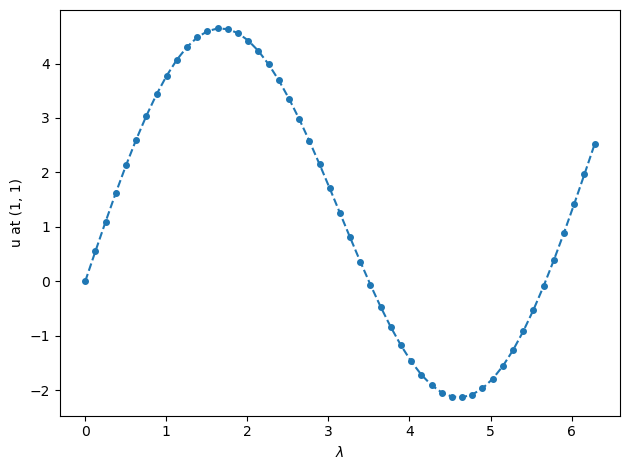

In [8]:
import matplotlib.pyplot as plt

if domain.comm.rank == 0:
    plt.plot(lmbda_list, u_bb_list, "o--", markersize=4)
    plt.xlabel(r"$\lambda$")
    plt.ylabel("u at (1, 1)")
    plt.tight_layout()
    plt.show()

# Custom Newton solver

In [9]:
from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import dolfinx.fem.petsc
import numpy as np
import ufl
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
def q(u):
    return 1 + u**2

domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
lmbda = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type(0.0))

x = ufl.SpatialCoordinate(domain)
u_ufl = (ufl.sin(lmbda) + 0.1* lmbda)*(1 + x[0]* x[0] + 2 * x[1]* x[1]) 

f = - ufl.div(q(u_ufl) * ufl.grad(u_ufl))

V = dolfinx.fem.functionspace(domain, ("Lagrange", 1))
u_D = dolfinx.fem.Function(V)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, fdim + 1)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
bc = dolfinx.fem.dirichletbc(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

uh = dolfinx.fem.Function(V)
v = ufl.TestFunction(V)
F = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - f * v * ufl.dx
J = ufl.derivative(F, uh)
residual = dolfinx.fem.form(F)
jacobian = dolfinx.fem.form(J)

In [11]:

bb_tree = dolfinx.geometry.bb_tree(domain, 2)
bb_point = np.array([[1.0, 1.0, 0.0]], dtype=np.float64)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point)
bb_cells = dolfinx.geometry.compute_colliding_cells(
    domain, cell_candidates, bb_point)

In [12]:
du = dolfinx.fem.Function(V)
A = dolfinx.fem.petsc.create_matrix(jacobian)
L = dolfinx.fem.petsc.create_vector(residual)
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [ ]:
uh.x.array[:] = 0.0

nstep = 51
Dlmbda = 2*np.pi / (nstep - 1)
u_bb_list = np.zeros(nstep)
lmbda_list = np.arange(0.0, nstep*Dlmbda, Dlmbda)
max_iterations = 25


for i, lm_value in enumerate(tqdm(lmbda_list)):
    lmbda.value = lm_value
    u_D.interpolate(dolfinx.fem.Expression(u_ufl, V.element.interpolation_points()))
    j = 0
    
    print(f"Step {i} starts, lambda = {lm_value:.2}")
    while j < max_iterations:
        # Assemble Jacobian and residual
        with L.localForm() as loc_L:
            loc_L.set(0)
        A.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A, jacobian, bcs=[bc])
        A.assemble()
        dolfinx.fem.petsc.assemble_vector(L, residual)
        L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        L.scale(-1)
        
        # Compute b - J(u_D-u_(i-1))
        dolfinx.fem.petsc.apply_lifting(L, [jacobian], [[bc]], x0=[uh.vector], scale=1)
        # Set du|_bc = u_{i-1}-u_D
        dolfinx.fem.petsc.set_bc(L, [bc], uh.vector, 1.0)
        L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)
        
        # Solve linear problem
        solver.solve(L, du.vector)
        du.x.scatter_forward()
        
        # Update u_{i+1} = u_i + delta u_i
        uh.x.array[:] += du.x.array
        j += 1
        
        # Compute norm of update
        correction_norm_0 = du.vector.norm(0)
        correction_norm_1 = du.vector.norm(1)
        
        print(f"    Iteration {j}; norm 0: {correction_norm_0:.2E}; norm 1: {correction_norm_1:.2E}")
        if correction_norm_0 < 1e-10 and correction_norm_1 < 1e-10:
            break
    if j == max_iterations:
        raise ValueError("    Warning: max iterations reached")
    
    u_bb = 0.0
    if len(bb_cells.array) > 0:
        u_bb = uh.eval(bb_point, bb_cells.array[0])[0]
    u_bb = domain.comm.allreduce(u_bb, op=MPI.SUM)
    u_bb_list[i] = u_bb
    error_max = domain.comm.allreduce(np.max(np.abs(uh.x.array - u_D.x.array)), op=MPI.MAX)
    error_L2 = np.sqrt(domain.comm.allreduce(dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(uh - u_ufl, uh - u_ufl) * ufl.dx)), op=MPI.SUM))
    
    print(f"Total iteration = {j}, Error_max: {error_max:.2E}; Error_L2: {error_L2:.2E} \n")

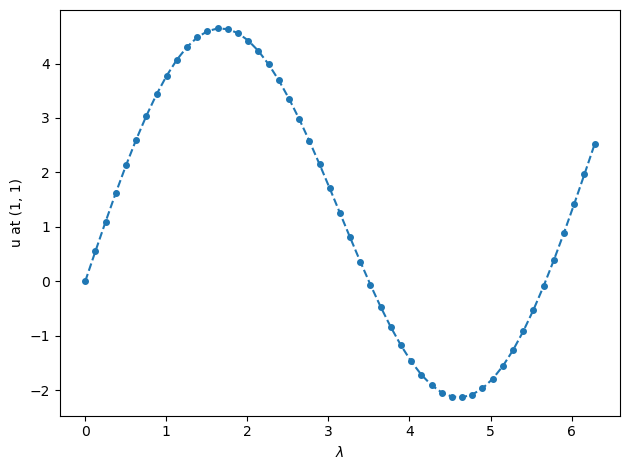

In [14]:
if domain.comm.rank == 0:
    plt.plot(lmbda_list, u_bb_list, "o--", markersize=4)
    plt.xlabel(r"$\lambda$")
    plt.ylabel("u at (1, 1)")
    plt.tight_layout()
    plt.show()

# Custom Arc length solver

In [1]:
from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import dolfinx.fem.petsc
import numpy as np
import ufl
from ArclengthProblem import ArclengthProblem

from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def q(u):
    return 1 + u**2

domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

x = ufl.SpatialCoordinate(domain)
u_ufl = 1 + x[0] + 2 * x[1]

f = - ufl.div(q(u_ufl) * ufl.grad(u_ufl))

V = dolfinx.fem.functionspace(domain, ("Lagrange", 1))
u_D = dolfinx.fem.Function(V)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, fdim + 1)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
bc = dolfinx.fem.dirichletbc(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

uh = dolfinx.fem.Function(V)
v = ufl.TestFunction(V)
u_trial = ufl.TrialFunction(V)

In [3]:
Fint = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx 
Fext = f * v * ufl.dx

J = ufl.derivative(Fint, uh, u_trial)

problem = ArclengthProblem(Fint, Fext, uh, lmbda0=0.0, bcs=[bc], J=J)

In [4]:
bb_tree = dolfinx.geometry.bb_tree(domain, 2)
bb_point = np.array([[1.0, 1.0, 0.0]], dtype=np.float64)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point)
bb_cells = dolfinx.geometry.compute_colliding_cells(
    domain, cell_candidates, bb_point)